# PN2V Training
Here we will use the estimated noise model (from the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```) and train a PN2V network on single noisy images.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

from ppn2v.unet.model import UNet
from ppn2v.pn2v import utils
from ppn2v.pn2v import gaussianMixtureNoiseModel
from ppn2v.pn2v import histNoiseModel
from ppn2v.pn2v import training
from tifffile import imread

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets from https://zenodo.org/record/5156913/files/Convallaria_diaphragm.zip?download=1 and created a noise model (GMM- and  histogram- based) using the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```). Ensure that for Convallaria, the data to be denoised is named ```20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif``` and not the diaphragm data. 

In [2]:
path='../../../data/Convallaria_diaphragm/'
# Load the training data
data=imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif')
dataName='convallaria'

Uncomment the pertinent `nameNoiseModel` to choose the noiseModel of interest

In [3]:
nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
#nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
# nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
#nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
if('HistNoiseModel' in namePN2VModel):
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
elif('GMMNoiseModel' in namePN2VModel):
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params = params, device = device)
    

### Create the Network and Train it
This can take a while.

In [5]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 3.7589275598526+-(2SEM)0.07839217941070668      
Epoch 1 finished      
avg. loss: 3.533452010154724+-(2SEM)0.1759516240865276      
Epoch 2 finished      
avg. loss: 3.3170129299163817+-(2SEM)0.1565587100690635      
Epoch 3 finished      
avg. loss: 3.2226125836372375+-(2SEM)0.14960979300192437      
Epoch 4 finished      
avg. loss: 3.09390549659729+-(2SEM)0.15001149687500584      
Epoch 5 finished      
avg. loss: 3.0440924644470213+-(2SEM)0.0997446121367127      
Epoch 6 finished      
avg. loss: 2.9616528153419495+-(2SEM)0.11408353147300745      
Epoch 7 finished      
avg. loss: 2.862036609649658+-(2SEM)0.10276180186942294      
Epoch 8 finished      
avg. loss: 2.85649174451828+-(2SEM)0.07562478005866598      
Epoch 9 finished      
avg. loss: 2.9037797808647157+-(2SEM)0.11027401001230407      
Epoch 10 finished      
avg. loss: 2.8171500325202943+-(2SEM)0.08787868850119761      
Epoch 11 finished      
avg. loss: 2.8267753958702087+-(2SEM)0.09

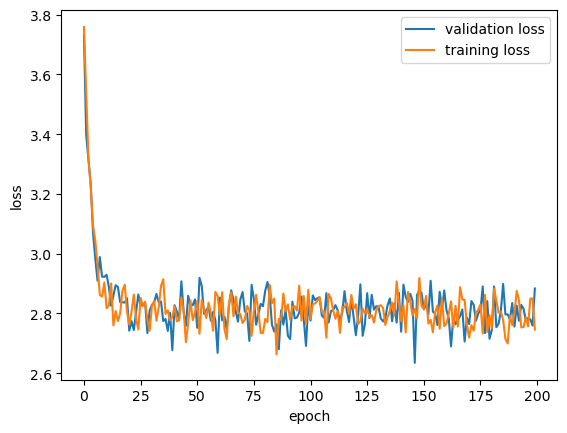

In [6]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()